# Deep Learning model의 class weight 조정

## DNN 이용, Class Weight 조정, OverSampling

- Data 는 이전 실습 문제와 동일한 [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) - Kaggle

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import  accuracy_score, precision_score, recall_score, \
                            roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
mpl.rcParams['figure.figsize'] = (12, 10)

### Kaggle Credit Card Fraud dataset 다운로드

In [2]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 클래스 레이블 불균형 조사

In [3]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [4]:
neg, pos = df['Class'].value_counts().values.tolist()
total = neg + pos
print(f'Total 건수: {total}\nPositive 건수/비율: {pos} ({pos/total*100:.2f}%)')

Total 건수: 284807
Positive 건수/비율: 492 (0.17%)


## Data 전처리 

- 2 일 동안의 data가 00:00:00 부터 발생했으므로 Time을 일중 시간으로 변경 : time / 3600 초 % 24 시간  
- Amount column 은 편차가 크므로 log-scale 로 변환

In [5]:
cleaned_df = df.copy()

# Time 을 일중 시간으로 변환
cleaned_df.loc[:, "Time"] = cleaned_df.loc[:, "Time"].apply(lambda x : x / 3600 % 24) 

# Amount column 은 편차가 크므로 log-scale 로 변환
eps=0.001     
cleaned_df['Amount'] = np.log(cleaned_df.pop('Amount') + eps)

cleaned_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367


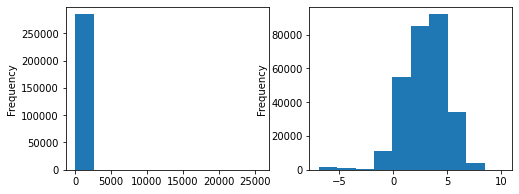

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
df['Amount'].plot(kind='hist', ax=ax1)
cleaned_df['Amount'].plot(kind='hist', ax=ax2)

In [7]:
labels = np.array(cleaned_df.pop('Class'))
labels

array([0, 0, 0, ..., 0, 0, 0])

In [8]:
features = cleaned_df.values
features.shape

(284807, 30)

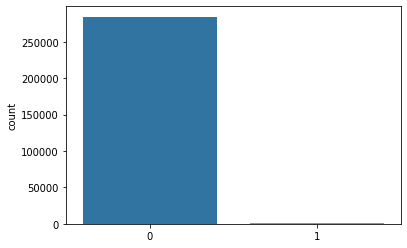

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x=labels)

### Dataset 을 Training 과 Test set 으로 분리

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                test_size=0.5, random_state=0, stratify=labels)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((142403, 30), (142404, 30), (142403,), (142404,))

In [11]:
print("전체 data의 positive 건수 : ", Counter(labels))
print("Train set 의 positive 건수 : ", Counter(y_train))
print("Test set 의 positive 건수 : ", Counter(y_test))

전체 data의 positive 건수 :  Counter({0: 284315, 1: 492})
Train set 의 positive 건수 :  Counter({0: 142157, 1: 246})
Test set 의 positive 건수 :  Counter({0: 142158, 1: 246})


## Feature Scaling

In [12]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

### Metrics 정의
- model train 중 측정할 metric  정의

In [13]:
METRICS = tf.keras.metrics.AUC(name='auc')

## Simple NN model 정의 - 이진 분류 모델

In [14]:
def make_model():
    model = tf.keras.Sequential([
      Dense(32, activation='relu', input_shape=(X_train.shape[-1],)),
      Dropout(0.2),
      Dense(16, activation='relu'),
      Dropout(0.2),
      Dense(1, activation='sigmoid'),
      ])

    model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
      loss = 'binary_crossentropy', metrics=[METRICS, 'accuracy'])

    return model

### Baseline model build

In [15]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,        # no of epochs of no improvement          
    mode='max',        #val_auc 가 10 번 연속 증가 안하면 stop           
    restore_best_weights=True)      # epoch 의 best weight 저장

In [16]:
base_model = make_model()
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                992       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [17]:
baseline_history = base_model.fit(X_train, y_train, batch_size=BATCH_SIZE,
                             epochs=EPOCHS, 
                             callbacks=[early_stopping], 
                             validation_data=(X_test, y_test))

Epoch 1/100
70/70 [==============================] - 3s 15ms/step - loss: 0.0642 - auc: 0.7183 - accuracy: 0.9773 - val_loss: 0.0047 - val_auc: 0.8958 - val_accuracy: 0.9993
Epoch 2/100
70/70 [==============================] - 1s 10ms/step - loss: 0.0051 - auc: 0.9261 - accuracy: 0.9991 - val_loss: 0.0042 - val_auc: 0.9021 - val_accuracy: 0.9993
Epoch 3/100
70/70 [==============================] - 1s 10ms/step - loss: 0.0042 - auc: 0.9268 - accuracy: 0.9993 - val_loss: 0.0037 - val_auc: 0.9302 - val_accuracy: 0.9994
Epoch 4/100
70/70 [==============================] - 1s 10ms/step - loss: 0.0039 - auc: 0.9354 - accuracy: 0.9993 - val_loss: 0.0037 - val_auc: 0.9285 - val_accuracy: 0.9993
Epoch 5/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0034 - auc: 0.9499 - accuracy: 0.9993 - val_loss: 0.0037 - val_auc: 0.9362 - val_accuracy: 0.9993
Epoch 6/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0032 - auc: 0.9600 - accuracy: 0.9994 - val_loss: 0.0037

In [18]:
baseline_history.history['val_accuracy'][-1]

0.9994171261787415

## Evaluate Metric

- confusion matrix 를 이용하여 metrics 요약

In [19]:
predictions_baseline  = base_model.predict(X_test)
predictions_baseline.shape

4451/4451 [==============================] - 6s 1ms/step


(142404, 1)

In [20]:
predictions_baseline.shape

(142404, 1)

In [21]:
def plot_cm(y_test, y_pred_prob, threshold):
    
    y_pred = y_pred_prob > threshold
    
    cm = confusion_matrix(y_test, y_pred)
    
    print("f1 score:", f1_score(y_test, y_pred))
    print("Accuracy", accuracy_score(y_test, y_pred))
    print("Precision", precision_score(y_test, y_pred))
    print("Recall", recall_score(y_test, y_pred))
    
    plt.figure(figsize=(5,5))

    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix (threshold>{:.2f}) '.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

### Test dataset 으로 모델을 평가 하고, confusion matrix 를 그린다

f1 score: 0.8212765957446808
Accuracy 0.9994101289289626
Precision 0.8616071428571429
Recall 0.7845528455284553


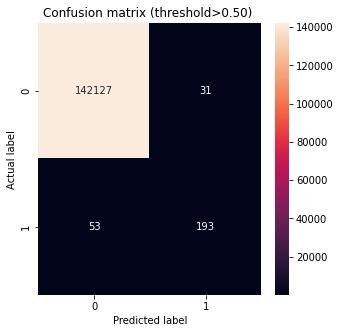

In [22]:
plot_cm(y_test, predictions_baseline, threshold=0.5)

## Class Weight 조정

사용할 positive 샘플이 많지 않기 때문에 가용한 적은 수의 sample 에 classifier 가 더 비중을 두도록 할 수 있다.  이는 모델이 과소 표현된 클래스의 샘플에 `더 많은주의를 기울이도록` 지시하는 데 유용.

step1 - 레이블 및 관련 가중치로 dictionary 정의 
```
class_weight ={0: 0.5008652375006595, 1: 289.43800813008136}
```                
step2 - dictionary를 매개 변수로 공급:  
```
    model.fit(X_train, Y_train, nb_epoch=5, batch_size=32, class_weight=class_weight)
```

- loss function 계산 시 class_weight 에 지정된 대로 가중 평균

In [23]:
neg, pos, total

(284315, 492, 284807)

In [24]:
weight_for_0 = (1 / neg)*(total)
weight_for_1 = (1 / pos)*(total)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.00
Weight for class 1: 578.88


In [25]:
class_weight

{0: 1.001730475001319, 1: 578.8760162601627}

In [26]:
weighted_model = make_model()

weighted_history = weighted_model.fit(X_train, y_train, 
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS, 
                                    callbacks = [early_stopping], 
                                    validation_data=(X_test, y_test),
                                    class_weight=class_weight) 

Epoch 1/100
70/70 [==============================] - 1s 11ms/step - loss: 0.6863 - auc: 0.9097 - accuracy: 0.8793 - val_loss: 0.0820 - val_auc: 0.9775 - val_accuracy: 0.9868
Epoch 2/100
70/70 [==============================] - 0s 7ms/step - loss: 0.3942 - auc: 0.9688 - accuracy: 0.9638 - val_loss: 0.1002 - val_auc: 0.9797 - val_accuracy: 0.9826
Epoch 3/100
70/70 [==============================] - 0s 7ms/step - loss: 0.3352 - auc: 0.9800 - accuracy: 0.9567 - val_loss: 0.1257 - val_auc: 0.9823 - val_accuracy: 0.9653
Epoch 4/100
70/70 [==============================] - 0s 6ms/step - loss: 0.2443 - auc: 0.9905 - accuracy: 0.9746 - val_loss: 0.1064 - val_auc: 0.9823 - val_accuracy: 0.9662
Epoch 5/100
70/70 [==============================] - 0s 6ms/step - loss: 0.2572 - auc: 0.9879 - accuracy: 0.9703 - val_loss: 0.0759 - val_auc: 0.9831 - val_accuracy: 0.9807
Epoch 6/100
70/70 [==============================] - 0s 6ms/step - loss: 0.2199 - auc: 0.9923 - accuracy: 0.9720 - val_loss: 0.0871 - 

In [27]:
predictions_weighted = weighted_model.predict(X_test)

4451/4451 [==============================] - 6s 1ms/step


loss :  0.08705693483352661
auc :  0.9843770265579224
accuracy :  0.9728027582168579

f1 score: 0.10450867052023123
Accuracy 0.972802730260386
Precision 0.05540573670017161
Recall 0.9186991869918699


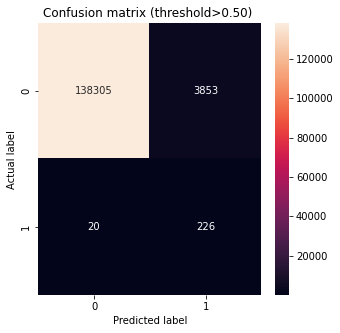

In [28]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(y_test, predictions_weighted, threshold=0.5)

## Plot the ROC

In [29]:
def plot_roc(name, labels, predictions, **kwargs):
    
    fp, tp, _ = roc_curve(labels, predictions)
    auc = roc_auc_score(y_test, predictions)
    
    plt.plot(100*fp, 100*tp, label=f"auc of {name}={auc:.5f}", linewidth=2, **kwargs)
    plt.xlabel('FP [%]')
    plt.ylabel('TP [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    fig = plt.gcf()
    fig.set_size_inches(8, 6)

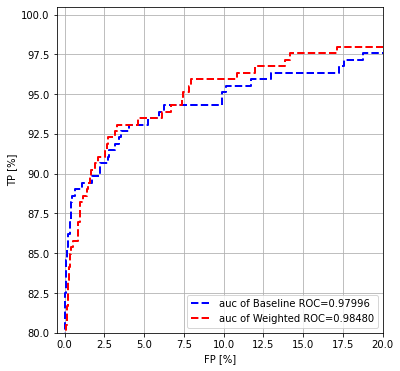

In [30]:
plot_roc("Baseline ROC", y_test, predictions_baseline, color='blue', linestyle='--')

plot_roc("Weighted ROC", y_test, predictions_weighted, color='red', linestyle='--')

plt.legend(loc='lower right')

## Next Step => Over+Under-sampling model과 weight 조절 DNN model 비교